<a id='Q0'></a>
<center> <h1>Telecom Churn Prediction (Classification) </h1> </center>
<p style="margin-bottom:1cm;"></p>
<center><h4>Propulsion Academy - Applied Machine Learning, April 2021</h4></center>
<p style="margin-bottom:1cm;"></p>

<div style="background:#EEEDF5;border-top:0.1cm solid #EF475B;border-bottom:0.1cm solid #EF475B;color:#303030">
    <div style="margin-left: 0.5cm;margin-top: 0.5cm;margin-bottom: 0.5cm">
        <p><strong>Goal:</strong> Use Kaggle Dataset for predicting the Churn (refusal of contract renewal) of some Telecom Customers.</p>
        <p> <strong> Outline:</strong>
        <a id="P0" name="P0"></a>
        <ol>
            <li> <a href='#I'>Import Libraries </a> </li>
            <li> <a href='#C1'>Data load and basic checks</a></li>
            <li> <a href='#C2'>Data Imputations and Cleansing</a></li>
            <li> <a href='#C3'>Exploratory Data Analysis</a></li>
            <li> <a href='#C4'>Preprocessing</a></li>
            <li> <a href='#C5'>Building models for prediction</a></li>
            <li> <a href='#C6'>Hyperparameter tuning</a></li>
            <li> <a href='#C7'>Compare model performance</a></li>
            <li> <a href='#C8'>Select final model and save model artifacts</a></li>
            <li> <a href='#C9'>Predict and draw conclusions</a></li>
        </ol>
     </div>
    <a href='https://www.kaggle.com/radmirzosimov/telecom-users-dataset'>Link to the Dataset</a>
</div>

<a name='I'></a>
## <font color='darkblue'>__Import Libraries__</font>

In [1]:
# General libraries
import os
import pathlib
import pandas as pd
import numpy as np
from scipy import stats
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Sckit-Learn processing libraries
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    precision_recall_curve,
    f1_score
)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [3]:
# Sckit-learn model libraries
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb

In [4]:
workdir = pathlib.Path().absolute()
project_dir = workdir.parent
data_path = f"{project_dir}\\datasets\\"

In [5]:
def f1_scorer(clf, X, y):
    y_pred = clf.predict(X)
    return f1_score(y, y_pred, pos_label='Yes')

<a name='C1'></a>
## <font color='darkblue'>__Data Load & Basic Checks__</font>

In [6]:
df = pd.read_csv(data_path+'telecom_users.csv')

In [7]:
df.tail()

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
5981,3772,0684-AOSIH,Male,0,Yes,No,1,Yes,No,Fiber optic,...,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,95.00,95,Yes
5982,5191,5982-PSMKW,Female,0,Yes,Yes,23,Yes,Yes,DSL,...,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),91.10,2198.3,No
5983,5226,8044-BGWPI,Male,0,Yes,Yes,12,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Electronic check,21.15,306.05,No
5984,5390,7450-NWRTR,Male,1,No,No,12,Yes,Yes,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.45,1200.15,Yes
5985,860,4795-UXVCJ,Male,0,No,No,26,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,One year,No,Credit card (automatic),19.80,457.3,No


In [8]:
df.shape

(5986, 22)

In [9]:
df.isna().sum()

Unnamed: 0          0
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5986 entries, 0 to 5985
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        5986 non-null   int64  
 1   customerID        5986 non-null   object 
 2   gender            5986 non-null   object 
 3   SeniorCitizen     5986 non-null   int64  
 4   Partner           5986 non-null   object 
 5   Dependents        5986 non-null   object 
 6   tenure            5986 non-null   int64  
 7   PhoneService      5986 non-null   object 
 8   MultipleLines     5986 non-null   object 
 9   InternetService   5986 non-null   object 
 10  OnlineSecurity    5986 non-null   object 
 11  OnlineBackup      5986 non-null   object 
 12  DeviceProtection  5986 non-null   object 
 13  TechSupport       5986 non-null   object 
 14  StreamingTV       5986 non-null   object 
 15  StreamingMovies   5986 non-null   object 
 16  Contract          5986 non-null   object 


In [11]:
df.loc[:, (df==0).any()]

,Unnamed: 0,SeniorCitizen,tenure
0,1869,0,72
1,4528,0,44
2,6344,1,38
3,6739,0,4
4,432,0,2
...,...,...,...
5981,3772,0,1
5982,5191,0,23
5983,5226,0,12
5984,5390,1,12


In [12]:
df[df['tenure']==0]

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
356,6754,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,DSL,...,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,,No
634,1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
2771,3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
3086,5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
3255,3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
4326,936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
5375,753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
5382,4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5695,488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
5951,1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No


In [13]:
df[df['SeniorCitizen']==0]

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1869,7010-BRBUU,Male,0,Yes,Yes,72,Yes,Yes,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,4528,9688-YGXVR,Female,0,No,No,44,Yes,No,Fiber optic,...,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.2,No
3,6739,6994-KERXL,Male,0,No,No,4,Yes,No,DSL,...,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.5,No
4,432,2181-UAESM,Male,0,No,No,2,Yes,No,DSL,...,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.5,No
5,2215,4312-GVYNH,Female,0,Yes,No,70,No,No phone service,DSL,...,Yes,Yes,No,Yes,Two year,Yes,Bank transfer (automatic),49.85,3370.2,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5980,3092,6032-IGALN,Female,0,No,No,1,No,No phone service,DSL,...,No,No,No,No,Month-to-month,Yes,Mailed check,25.10,25.1,Yes
5981,3772,0684-AOSIH,Male,0,Yes,No,1,Yes,No,Fiber optic,...,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,95.00,95,Yes
5982,5191,5982-PSMKW,Female,0,Yes,Yes,23,Yes,Yes,DSL,...,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),91.10,2198.3,No
5983,5226,8044-BGWPI,Male,0,Yes,Yes,12,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Electronic check,21.15,306.05,No


In [14]:
df[(df==' ')].any()

Unnamed: 0          False
customerID          False
gender              False
SeniorCitizen       False
Partner             False
Dependents          False
tenure              False
PhoneService        False
MultipleLines       False
InternetService     False
OnlineSecurity      False
OnlineBackup        False
DeviceProtection    False
TechSupport         False
StreamingTV         False
StreamingMovies     False
Contract            False
PaperlessBilling    False
PaymentMethod       False
MonthlyCharges      False
TotalCharges         True
Churn               False
dtype: bool

In [15]:
df[df['TotalCharges']==" "]

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
356,6754,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,DSL,...,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,,No
634,1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
2771,3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
3086,5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
3255,3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
4326,936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
5375,753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
5382,4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5695,488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
5951,1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No


In [16]:
df['Contract'].value_counts()

Month-to-month    3269
Two year          1441
One year          1276
Name: Contract, dtype: int64

In [17]:
df.duplicated().sum()

0

In [18]:
df.nunique()

Unnamed: 0          5986
customerID          5986
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1526
TotalCharges        5611
Churn                  2
dtype: int64

In [19]:
df[df['customerID'].isna()]

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


<a name='C2'></a>
## <font color='darkblue'>__Data Imputations and Cleansing__</font>

<p>We have to make the following basic conversions:</p>
<li>drop the column "Unnamed: 0"</li>
<li>convert the column  "SeniorCitizen" back to dtype(object) and the values to Yes, No (from 1, 0)</li>
<li>impute the  empty records in column "TotalCharges" - they are customers, which are there with tenure 0 (less than a month) their charge can be equal to a monthly charge</li>
<li>convert the column "TotalCharge" to dtype(float64)</li>
<li>correct the zero values in column "tenure" to 1 (with the assumption that customers in the dataset have min one month tenure - it does not make a difference for churn prediction)</li>

We remove the "Unnamed: 0" column

In [20]:
final_columns = set(df.columns) - set(['Unnamed: 0'])
final_columns = list(final_columns)
final_columns

['gender',
 'tenure',
 'PaymentMethod',
 'InternetService',
 'OnlineSecurity',
 'TechSupport',
 'PaperlessBilling',
 'MonthlyCharges',
 'MultipleLines',
 'Churn',
 'PhoneService',
 'Dependents',
 'SeniorCitizen',
 'OnlineBackup',
 'StreamingTV',
 'Partner',
 'TotalCharges',
 'customerID',
 'DeviceProtection',
 'StreamingMovies',
 'Contract']

In [21]:
df_selected = df.copy()
df_selected = df_selected[final_columns]
df_selected.head()

,gender,tenure,PaymentMethod,InternetService,OnlineSecurity,TechSupport,PaperlessBilling,MonthlyCharges,MultipleLines,Churn,...,Dependents,SeniorCitizen,OnlineBackup,StreamingTV,Partner,TotalCharges,customerID,DeviceProtection,StreamingMovies,Contract
0,Male,72,Credit card (automatic),No,No internet service,No internet service,No,24.10,Yes,No,...,Yes,0,No internet service,No internet service,Yes,1734.65,7010-BRBUU,No internet service,No internet service,Two year
1,Female,44,Credit card (automatic),Fiber optic,No,No,Yes,88.15,No,No,...,No,0,Yes,Yes,No,3973.2,9688-YGXVR,Yes,No,Month-to-month
2,Female,38,Bank transfer (automatic),Fiber optic,No,No,Yes,74.95,Yes,Yes,...,No,1,No,No,Yes,2869.85,9286-DOJGF,No,No,Month-to-month
3,Male,4,Electronic check,DSL,No,No,Yes,55.90,No,No,...,No,0,No,No,No,238.5,6994-KERXL,No,Yes,Month-to-month
4,Male,2,Electronic check,DSL,Yes,No,No,53.45,No,No,...,No,0,No,No,No,119.5,2181-UAESM,Yes,No,Month-to-month


In [22]:
df_selected['SeniorCitizen'] = df_selected['SeniorCitizen'].replace({0: "No", 1: "Yes"})

In [23]:
df_selected['TotalCharges'] = df_selected['TotalCharges'].replace({" ": np.nan})

In [24]:
df_selected[df_selected['TotalCharges'].isna()]

,gender,tenure,PaymentMethod,InternetService,OnlineSecurity,TechSupport,PaperlessBilling,MonthlyCharges,MultipleLines,Churn,...,Dependents,SeniorCitizen,OnlineBackup,StreamingTV,Partner,TotalCharges,customerID,DeviceProtection,StreamingMovies,Contract
356,Male,0,Bank transfer (automatic),DSL,Yes,Yes,Yes,61.90,Yes,No,...,Yes,No,Yes,No,No,NaN,2775-SEFEE,No,No,Two year
634,Female,0,Credit card (automatic),DSL,Yes,Yes,No,56.05,No phone service,No,...,Yes,No,Yes,Yes,Yes,NaN,1371-DWPAZ,Yes,No,Two year
2771,Male,0,Mailed check,No,No internet service,No internet service,No,25.35,Yes,No,...,Yes,No,No internet service,No internet service,Yes,NaN,3213-VVOLG,No internet service,No internet service,Two year
3086,Male,0,Mailed check,No,No internet service,No internet service,Yes,19.70,No,No,...,Yes,No,No internet service,No internet service,Yes,NaN,2923-ARZLG,No internet service,No internet service,One year
3255,Male,0,Mailed check,No,No internet service,No internet service,No,19.85,No,No,...,Yes,No,No internet service,No internet service,Yes,NaN,7644-OMVMY,No internet service,No internet service,Two year
4326,Female,0,Mailed check,DSL,Yes,No,No,80.85,No,No,...,Yes,No,Yes,Yes,Yes,NaN,5709-LVOEQ,Yes,Yes,Two year
5375,Male,0,Mailed check,No,No internet service,No internet service,No,20.25,No,No,...,Yes,No,No internet service,No internet service,No,NaN,3115-CZMZD,No internet service,No internet service,Two year
5382,Female,0,Mailed check,No,No internet service,No internet service,No,20.00,No,No,...,Yes,No,No internet service,No internet service,Yes,NaN,2520-SGTTA,No internet service,No internet service,Two year
5695,Female,0,Bank transfer (automatic),DSL,Yes,Yes,Yes,52.55,No phone service,No,...,Yes,No,No,Yes,Yes,NaN,4472-LVYGI,Yes,No,Two year
5951,Male,0,Mailed check,No,No internet service,No internet service,No,25.75,Yes,No,...,Yes,No,No internet service,No internet service,Yes,NaN,4367-NUYAO,No internet service,No internet service,Two year


In [25]:
df_selected['TotalCharges'] = np.where(df_selected['TotalCharges'].isnull(), df_selected['MonthlyCharges'], df_selected['TotalCharges'])

In [26]:
df_selected['TotalCharges'] = df_selected['TotalCharges'].astype(float)

In [27]:
df_selected[df_selected['tenure']==0]

,gender,tenure,PaymentMethod,InternetService,OnlineSecurity,TechSupport,PaperlessBilling,MonthlyCharges,MultipleLines,Churn,...,Dependents,SeniorCitizen,OnlineBackup,StreamingTV,Partner,TotalCharges,customerID,DeviceProtection,StreamingMovies,Contract
356,Male,0,Bank transfer (automatic),DSL,Yes,Yes,Yes,61.90,Yes,No,...,Yes,No,Yes,No,No,61.90,2775-SEFEE,No,No,Two year
634,Female,0,Credit card (automatic),DSL,Yes,Yes,No,56.05,No phone service,No,...,Yes,No,Yes,Yes,Yes,56.05,1371-DWPAZ,Yes,No,Two year
2771,Male,0,Mailed check,No,No internet service,No internet service,No,25.35,Yes,No,...,Yes,No,No internet service,No internet service,Yes,25.35,3213-VVOLG,No internet service,No internet service,Two year
3086,Male,0,Mailed check,No,No internet service,No internet service,Yes,19.70,No,No,...,Yes,No,No internet service,No internet service,Yes,19.70,2923-ARZLG,No internet service,No internet service,One year
3255,Male,0,Mailed check,No,No internet service,No internet service,No,19.85,No,No,...,Yes,No,No internet service,No internet service,Yes,19.85,7644-OMVMY,No internet service,No internet service,Two year
4326,Female,0,Mailed check,DSL,Yes,No,No,80.85,No,No,...,Yes,No,Yes,Yes,Yes,80.85,5709-LVOEQ,Yes,Yes,Two year
5375,Male,0,Mailed check,No,No internet service,No internet service,No,20.25,No,No,...,Yes,No,No internet service,No internet service,No,20.25,3115-CZMZD,No internet service,No internet service,Two year
5382,Female,0,Mailed check,No,No internet service,No internet service,No,20.00,No,No,...,Yes,No,No internet service,No internet service,Yes,20.00,2520-SGTTA,No internet service,No internet service,Two year
5695,Female,0,Bank transfer (automatic),DSL,Yes,Yes,Yes,52.55,No phone service,No,...,Yes,No,No,Yes,Yes,52.55,4472-LVYGI,Yes,No,Two year
5951,Male,0,Mailed check,No,No internet service,No internet service,No,25.75,Yes,No,...,Yes,No,No internet service,No internet service,Yes,25.75,4367-NUYAO,No internet service,No internet service,Two year


In [28]:
df_selected['tenure'] = df_selected['tenure'].replace({0: 1})

In [29]:
df_selected[df_selected['tenure']==1]

,gender,tenure,PaymentMethod,InternetService,OnlineSecurity,TechSupport,PaperlessBilling,MonthlyCharges,MultipleLines,Churn,...,Dependents,SeniorCitizen,OnlineBackup,StreamingTV,Partner,TotalCharges,customerID,DeviceProtection,StreamingMovies,Contract
7,Female,1,Mailed check,DSL,No,No,Yes,24.90,No phone service,No,...,No,No,No,No,No,24.90,4367-NHWMM,No,No,Month-to-month
16,Male,1,Mailed check,Fiber optic,No,Yes,Yes,74.30,No,No,...,No,No,No,No,No,74.30,2468-SJFLM,No,No,Month-to-month
24,Female,1,Electronic check,Fiber optic,No,No,Yes,69.65,No,Yes,...,No,Yes,No,No,No,69.65,4871-JTKJF,No,No,Month-to-month
26,Female,1,Mailed check,DSL,No,No,No,45.10,No,Yes,...,No,Yes,No,No,No,45.10,4193-ORFCL,No,No,Month-to-month
27,Female,1,Mailed check,No,No internet service,No internet service,Yes,25.75,Yes,No,...,No,No,No internet service,No internet service,No,25.75,2692-PFYTJ,No internet service,No internet service,Month-to-month
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5951,Male,1,Mailed check,No,No internet service,No internet service,No,25.75,Yes,No,...,Yes,No,No internet service,No internet service,Yes,25.75,4367-NUYAO,No internet service,No internet service,Two year
5952,Female,1,Electronic check,Fiber optic,No,No,Yes,74.70,No,Yes,...,Yes,No,Yes,No,Yes,74.70,9399-APLBT,No,No,Month-to-month
5973,Female,1,Mailed check,Fiber optic,No,No,Yes,76.40,No,Yes,...,No,Yes,Yes,No,Yes,76.40,3296-SILRA,No,No,Month-to-month
5980,Female,1,Mailed check,DSL,No,No,Yes,25.10,No phone service,Yes,...,No,No,No,No,No,25.10,6032-IGALN,No,No,Month-to-month


In [30]:
df_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5986 entries, 0 to 5985
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5986 non-null   object 
 1   tenure            5986 non-null   int64  
 2   PaymentMethod     5986 non-null   object 
 3   InternetService   5986 non-null   object 
 4   OnlineSecurity    5986 non-null   object 
 5   TechSupport       5986 non-null   object 
 6   PaperlessBilling  5986 non-null   object 
 7   MonthlyCharges    5986 non-null   float64
 8   MultipleLines     5986 non-null   object 
 9   Churn             5986 non-null   object 
 10  PhoneService      5986 non-null   object 
 11  Dependents        5986 non-null   object 
 12  SeniorCitizen     5986 non-null   object 
 13  OnlineBackup      5986 non-null   object 
 14  StreamingTV       5986 non-null   object 
 15  Partner           5986 non-null   object 
 16  TotalCharges      5986 non-null   float64


In [31]:
df_selected.tail()

,gender,tenure,PaymentMethod,InternetService,OnlineSecurity,TechSupport,PaperlessBilling,MonthlyCharges,MultipleLines,Churn,...,Dependents,SeniorCitizen,OnlineBackup,StreamingTV,Partner,TotalCharges,customerID,DeviceProtection,StreamingMovies,Contract
5981,Male,1,Electronic check,Fiber optic,Yes,No,Yes,95.00,No,Yes,...,No,No,No,Yes,Yes,95.00,0684-AOSIH,No,Yes,Month-to-month
5982,Female,23,Credit card (automatic),DSL,Yes,Yes,Yes,91.10,Yes,No,...,Yes,No,Yes,Yes,Yes,2198.30,5982-PSMKW,Yes,Yes,Two year
5983,Male,12,Electronic check,No,No internet service,No internet service,Yes,21.15,No,No,...,Yes,No,No internet service,No internet service,Yes,306.05,8044-BGWPI,No internet service,No internet service,Month-to-month
5984,Male,12,Electronic check,Fiber optic,No,No,Yes,99.45,Yes,Yes,...,No,Yes,No,Yes,No,1200.15,7450-NWRTR,Yes,Yes,Month-to-month
5985,Male,26,Credit card (automatic),No,No internet service,No internet service,No,19.80,No,No,...,No,No,No internet service,No internet service,No,457.30,4795-UXVCJ,No internet service,No internet service,One year


<a name='C3'></a>
## <font color='darkblue'>__Exploratory Data Analysis (EDA)__</font>

In [32]:
df_selected.isna().sum()

gender              0
tenure              0
PaymentMethod       0
InternetService     0
OnlineSecurity      0
TechSupport         0
PaperlessBilling    0
MonthlyCharges      0
MultipleLines       0
Churn               0
PhoneService        0
Dependents          0
SeniorCitizen       0
OnlineBackup        0
StreamingTV         0
Partner             0
TotalCharges        0
customerID          0
DeviceProtection    0
StreamingMovies     0
Contract            0
dtype: int64

### Visualizing relationship between churn and categorical variables

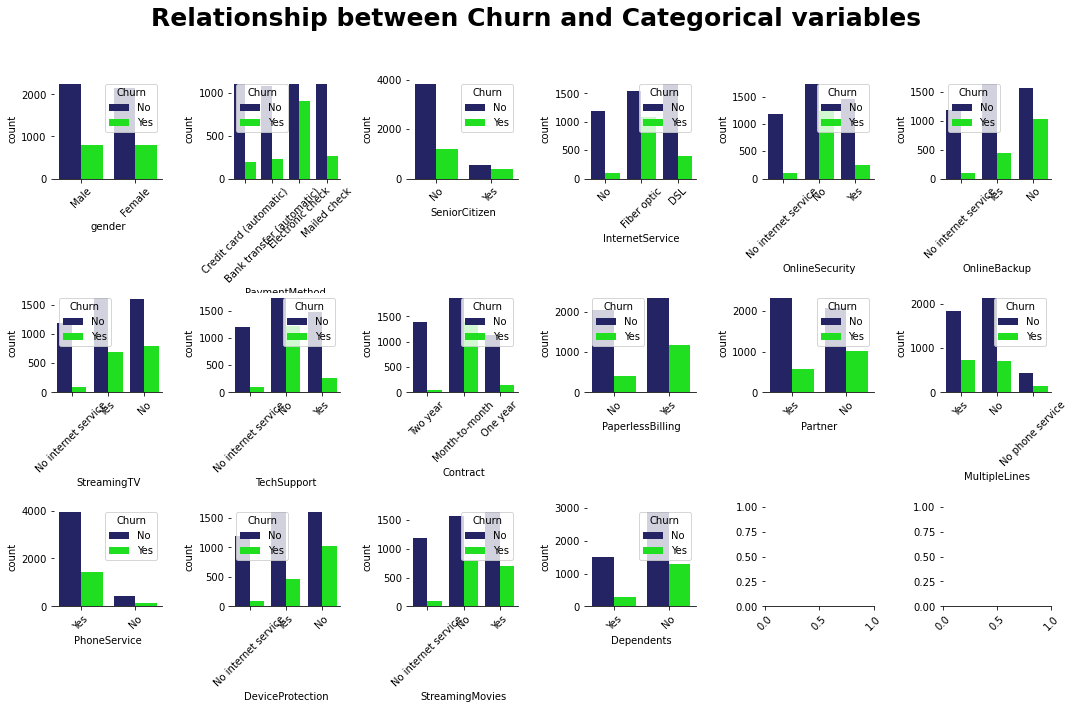

In [33]:
cat_features = set(df_selected.columns) - set(['tenure', 'Churn', 'MonthlyCharges', 'TotalCharges', 'customerID']) 

fig, axs = plt.subplots(ncols=6, nrows=3, figsize=(15,10))
for feat_num, feat_name in enumerate(cat_features):
    sns.countplot(data=df_selected, x=feat_name, hue='Churn', ax=axs[int(feat_num/6), feat_num%6], palette=['midnightblue', 'lime'])
    sns.despine(left=True)
for ax, dat in zip(axs.ravel(), df_selected):
    ax.tick_params(axis='x', labelrotation=45)
plt.tight_layout()
plt.suptitle("Relationship between Churn and Categorical variables", fontsize = 25, fontweight = 'bold')
fig.subplots_adjust(top=0.88)
plt.show()

### Visualizing numerical variables

In [34]:
df_selected.describe()

,tenure,MonthlyCharges,TotalCharges
count,5986.000000,5986.000000,5986.000000
mean,32.470431,64.802213,2294.285416
std,24.514212,30.114702,2274.100395
min,1.000000,18.250000,18.800000
25%,9.000000,35.650000,401.587500
50%,29.000000,70.400000,1408.575000
75%,56.000000,89.900000,3841.500000
max,72.000000,118.750000,8684.800000


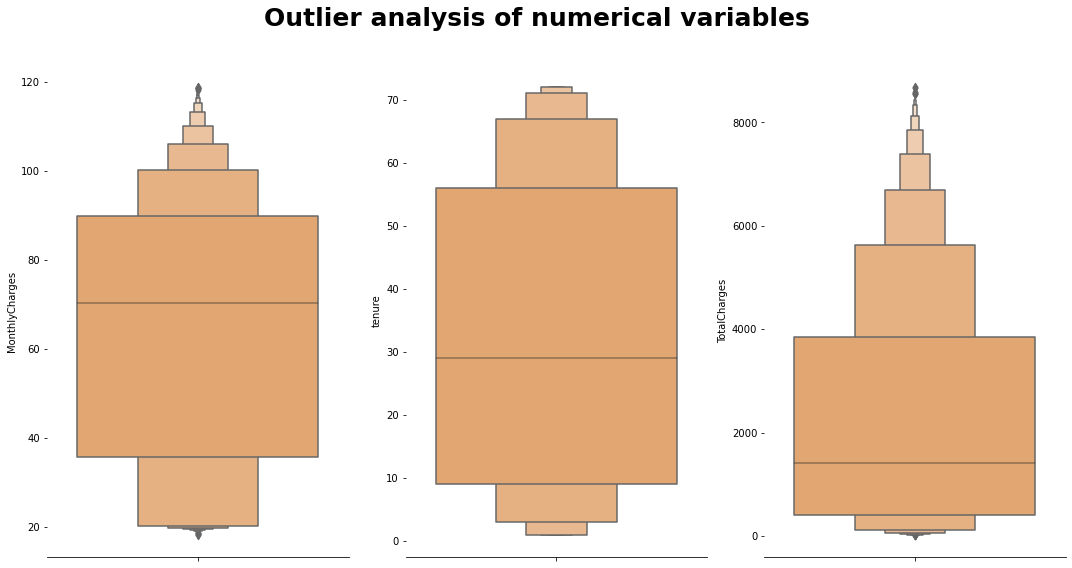

In [35]:
num_features = set(['tenure', 'MonthlyCharges', 'TotalCharges']) 

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15,8))
for feat_num, feat_name in enumerate(num_features):
    sns.boxenplot(y=df_selected[feat_name], ax=axs[feat_num%3], palette=['sandybrown'])
    sns.despine(left=True)
plt.tight_layout()
plt.suptitle("Outlier analysis of numerical variables", fontsize = 25, fontweight = 'bold')
fig.subplots_adjust(top=0.88)
plt.show()

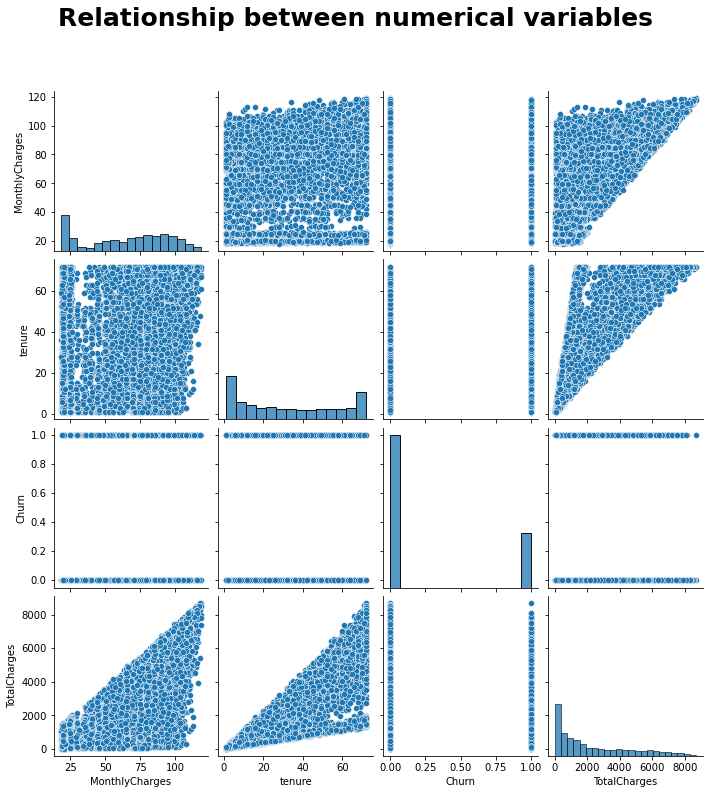

In [36]:
num_features_churn = num_features.copy()
num_features_churn.add('Churn')
df_pair = df_selected[num_features_churn].replace({'Yes': 1, 'No': 0})
sns.pairplot(df_pair)
plt.suptitle("Relationship between numerical variables", fontsize = 25, fontweight = 'bold', y=1.1)
plt.show()

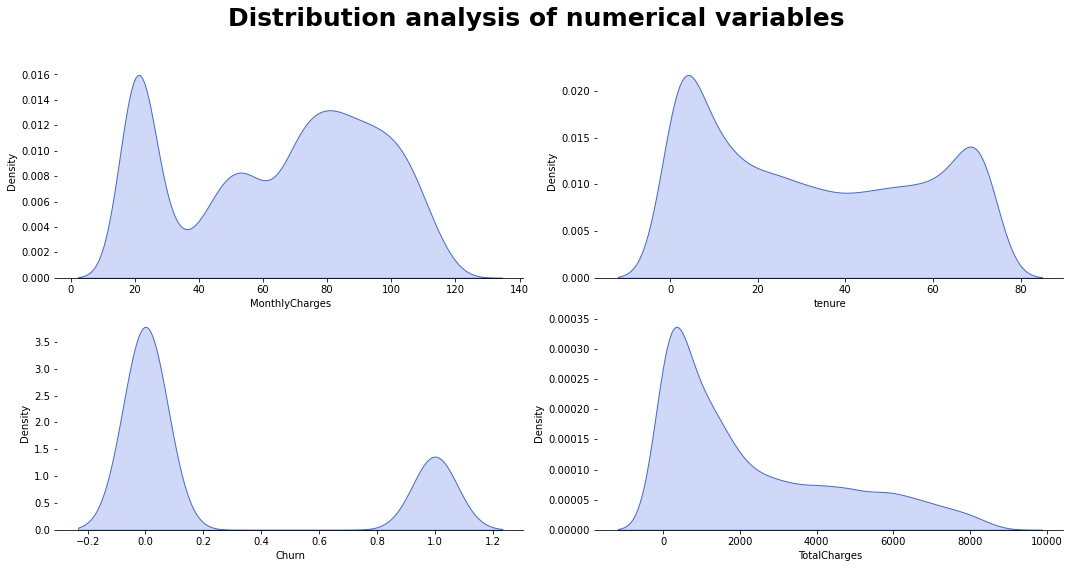

In [37]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15,8))
for feat_num, feat_name in enumerate(num_features_churn):
    sns.kdeplot(df_pair[feat_name], ax=axs[int(feat_num/2), feat_num%2], fill=True, color='royalblue')
    sns.despine(left=True)
plt.tight_layout()
plt.suptitle("Distribution analysis of numerical variables", fontsize = 25, fontweight = 'bold')
fig.subplots_adjust(top=0.88)
plt.show()

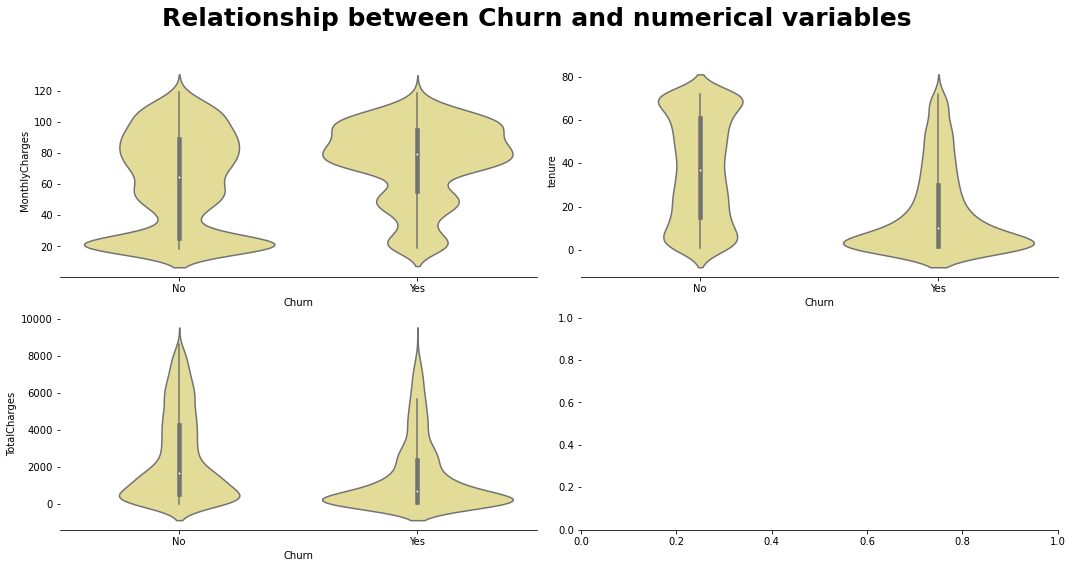

In [38]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15,8))
for feat_num, feat_name in enumerate(num_features):
    sns.violinplot(x='Churn', y=feat_name, data=df_selected, ax=axs[int(feat_num/2), feat_num%2], palette=['khaki'])
    sns.despine(left=True)
plt.tight_layout()
plt.suptitle("Relationship between Churn and numerical variables", fontsize = 25, fontweight = 'bold')
fig.subplots_adjust(top=0.88)
plt.show()

<a name='C4'></a>
## <font color='darkblue'>__Preprocessing__</font>

### Split Dataset into train and test

In [39]:
X = df_selected.drop(columns=['Churn', 'customerID'])
y = df_selected['Churn']

In [40]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5986 entries, 0 to 5985
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5986 non-null   object 
 1   tenure            5986 non-null   int64  
 2   PaymentMethod     5986 non-null   object 
 3   InternetService   5986 non-null   object 
 4   OnlineSecurity    5986 non-null   object 
 5   TechSupport       5986 non-null   object 
 6   PaperlessBilling  5986 non-null   object 
 7   MonthlyCharges    5986 non-null   float64
 8   MultipleLines     5986 non-null   object 
 9   PhoneService      5986 non-null   object 
 10  Dependents        5986 non-null   object 
 11  SeniorCitizen     5986 non-null   object 
 12  OnlineBackup      5986 non-null   object 
 13  StreamingTV       5986 non-null   object 
 14  Partner           5986 non-null   object 
 15  TotalCharges      5986 non-null   float64
 16  DeviceProtection  5986 non-null   object 


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [42]:
X_train.shape, X_test.shape

((4190, 19), (1796, 19))

In [43]:
y_train.value_counts()

No     3079
Yes    1111
Name: Churn, dtype: int64

In [44]:
y_test.value_counts()

No     1320
Yes     476
Name: Churn, dtype: int64

In [45]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4190 entries, 3499 to 5829
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            4190 non-null   object 
 1   tenure            4190 non-null   int64  
 2   PaymentMethod     4190 non-null   object 
 3   InternetService   4190 non-null   object 
 4   OnlineSecurity    4190 non-null   object 
 5   TechSupport       4190 non-null   object 
 6   PaperlessBilling  4190 non-null   object 
 7   MonthlyCharges    4190 non-null   float64
 8   MultipleLines     4190 non-null   object 
 9   PhoneService      4190 non-null   object 
 10  Dependents        4190 non-null   object 
 11  SeniorCitizen     4190 non-null   object 
 12  OnlineBackup      4190 non-null   object 
 13  StreamingTV       4190 non-null   object 
 14  Partner           4190 non-null   object 
 15  TotalCharges      4190 non-null   float64
 16  DeviceProtection  4190 non-null   objec

In [46]:
X_train_cat = X_train.select_dtypes(include='object')
X_train_num = X_train.select_dtypes(exclude='object')

In [47]:
X_train_cat.head()

,gender,PaymentMethod,InternetService,OnlineSecurity,TechSupport,PaperlessBilling,MultipleLines,PhoneService,Dependents,SeniorCitizen,OnlineBackup,StreamingTV,Partner,DeviceProtection,StreamingMovies,Contract
3499,Male,Bank transfer (automatic),No,No internet service,No internet service,No,No,Yes,No,No,No internet service,No internet service,No,No internet service,No internet service,One year
579,Male,Credit card (automatic),Fiber optic,Yes,Yes,No,Yes,Yes,No,No,Yes,Yes,No,Yes,No,One year
3722,Male,Credit card (automatic),Fiber optic,No,Yes,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Yes,Yes,Two year
247,Female,Credit card (automatic),DSL,Yes,Yes,No,No phone service,No,Yes,No,No,No,Yes,No,No,One year
5154,Male,Electronic check,Fiber optic,No,No,Yes,Yes,Yes,No,No,No,Yes,Yes,No,No,Month-to-month


In [48]:
X_train_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4190 entries, 3499 to 5829
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   gender            4190 non-null   object
 1   PaymentMethod     4190 non-null   object
 2   InternetService   4190 non-null   object
 3   OnlineSecurity    4190 non-null   object
 4   TechSupport       4190 non-null   object
 5   PaperlessBilling  4190 non-null   object
 6   MultipleLines     4190 non-null   object
 7   PhoneService      4190 non-null   object
 8   Dependents        4190 non-null   object
 9   SeniorCitizen     4190 non-null   object
 10  OnlineBackup      4190 non-null   object
 11  StreamingTV       4190 non-null   object
 12  Partner           4190 non-null   object
 13  DeviceProtection  4190 non-null   object
 14  StreamingMovies   4190 non-null   object
 15  Contract          4190 non-null   object
dtypes: object(16)
memory usage: 556.5+ KB


In [49]:
X_train_cat.loc[:, (X_train_cat==" ").any()]

""
3499
579
3722
247
5154
...
3339
4496
3202
782


In [50]:
X_train_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4190 entries, 3499 to 5829
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tenure          4190 non-null   int64  
 1   MonthlyCharges  4190 non-null   float64
 2   TotalCharges    4190 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 130.9 KB


In [51]:
X_train_num.loc[:, (X_train_num==0).any()]

""
3499
579
3722
247
5154
...
3339
4496
3202
782


### Impute missing data in Categorical Features

In [52]:
cat_cols = X_train_cat.columns
cat_imputer = SimpleImputer(strategy='constant', fill_value='Not Available', verbose=1)
X_train_cat = pd.DataFrame(cat_imputer.fit_transform(X_train_cat), columns=cat_cols)

### One-Hot Encoding Categorical Features

In [53]:
cat_dummy_encoder = OneHotEncoder(handle_unknown='ignore')
X_train_cat_ohe = cat_dummy_encoder.fit_transform(X_train_cat).toarray()
X_train_cat_ohe, cat_dummy_encoder.get_feature_names(cat_cols)

(array([[0., 1., 1., ..., 0., 1., 0.],
        [0., 1., 0., ..., 0., 1., 0.],
        [0., 1., 0., ..., 0., 0., 1.],
        ...,
        [0., 1., 0., ..., 1., 0., 0.],
        [0., 1., 0., ..., 0., 1., 0.],
        [1., 0., 0., ..., 0., 0., 1.]]),
 array(['gender_Female', 'gender_Male',
        'PaymentMethod_Bank transfer (automatic)',
        'PaymentMethod_Credit card (automatic)',
        'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
        'InternetService_DSL', 'InternetService_Fiber optic',
        'InternetService_No', 'OnlineSecurity_No',
        'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
        'TechSupport_No', 'TechSupport_No internet service',
        'TechSupport_Yes', 'PaperlessBilling_No', 'PaperlessBilling_Yes',
        'MultipleLines_No', 'MultipleLines_No phone service',
        'MultipleLines_Yes', 'PhoneService_No', 'PhoneService_Yes',
        'Dependents_No', 'Dependents_Yes', 'SeniorCitizen_No',
        'SeniorCitizen_Yes', '

In [54]:
X_train_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4190 entries, 0 to 4189
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   gender            4190 non-null   object
 1   PaymentMethod     4190 non-null   object
 2   InternetService   4190 non-null   object
 3   OnlineSecurity    4190 non-null   object
 4   TechSupport       4190 non-null   object
 5   PaperlessBilling  4190 non-null   object
 6   MultipleLines     4190 non-null   object
 7   PhoneService      4190 non-null   object
 8   Dependents        4190 non-null   object
 9   SeniorCitizen     4190 non-null   object
 10  OnlineBackup      4190 non-null   object
 11  StreamingTV       4190 non-null   object
 12  Partner           4190 non-null   object
 13  DeviceProtection  4190 non-null   object
 14  StreamingMovies   4190 non-null   object
 15  Contract          4190 non-null   object
dtypes: object(16)
memory usage: 523.9+ KB


In [55]:
cat_ohe_cols = cat_dummy_encoder.get_feature_names(cat_cols)
X_train_cat_ohe = pd.DataFrame(X_train_cat_ohe,
                              columns=cat_ohe_cols)

In [56]:
X_train_cat_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4190 entries, 0 to 4189
Data columns (total 43 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   gender_Female                            4190 non-null   float64
 1   gender_Male                              4190 non-null   float64
 2   PaymentMethod_Bank transfer (automatic)  4190 non-null   float64
 3   PaymentMethod_Credit card (automatic)    4190 non-null   float64
 4   PaymentMethod_Electronic check           4190 non-null   float64
 5   PaymentMethod_Mailed check               4190 non-null   float64
 6   InternetService_DSL                      4190 non-null   float64
 7   InternetService_Fiber optic              4190 non-null   float64
 8   InternetService_No                       4190 non-null   float64
 9   OnlineSecurity_No                        4190 non-null   float64
 10  OnlineSecurity_No internet service       4190 no

In [57]:
X_train_cat_ohe.tail()

,gender_Female,gender_Male,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,...,Partner_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year
4185,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4186,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4187,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4188,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4189,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


### Remove duplicate columns

<p>For some categories, there is an answer: "No Internet service" or "No phone service", but we have categories, which filter for the missing internet or phone service.</p>
<p>Therefore after One-Hot encoding these answers will become separate columns, but these columns have no added value for the model, so we can drop them accordingly.</p>

In [58]:
X_train_cat_ohe[['InternetService_No', 'DeviceProtection_No internet service', 'TechSupport_No internet service', 'OnlineSecurity_No internet service', 'StreamingMovies_No internet service',
                'StreamingTV_No internet service', 'OnlineBackup_No internet service']]

,InternetService_No,DeviceProtection_No internet service,TechSupport_No internet service,OnlineSecurity_No internet service,StreamingMovies_No internet service,StreamingTV_No internet service,OnlineBackup_No internet service
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
4185,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4186,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4187,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4188,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
X_train_cat_ohe[['InternetService_No', 'DeviceProtection_No internet service', 'TechSupport_No internet service', 'OnlineSecurity_No internet service', 'StreamingMovies_No internet service',
                'StreamingTV_No internet service', 'OnlineBackup_No internet service']].sum()

InternetService_No                      919.0
DeviceProtection_No internet service    919.0
TechSupport_No internet service         919.0
OnlineSecurity_No internet service      919.0
StreamingMovies_No internet service     919.0
StreamingTV_No internet service         919.0
OnlineBackup_No internet service        919.0
dtype: float64

In [60]:
X_train_cat_ohe[['PhoneService_No', 'MultipleLines_No phone service']]

,PhoneService_No,MultipleLines_No phone service
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,1.0,1.0
4,0.0,0.0
...,...,...
4185,0.0,0.0
4186,0.0,0.0
4187,0.0,0.0
4188,0.0,0.0


In [61]:
X_train_cat_ohe[['PhoneService_No', 'MultipleLines_No phone service']].sum()

PhoneService_No                   419.0
MultipleLines_No phone service    419.0
dtype: float64

In [62]:
X_train_cat_ohe = X_train_cat_ohe.drop(columns=['DeviceProtection_No internet service', 'TechSupport_No internet service', 'OnlineSecurity_No internet service', 'StreamingMovies_No internet service',
                'StreamingTV_No internet service', 'OnlineBackup_No internet service', 'MultipleLines_No phone service'])

In [63]:
X_train_cat_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4190 entries, 0 to 4189
Data columns (total 36 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   gender_Female                            4190 non-null   float64
 1   gender_Male                              4190 non-null   float64
 2   PaymentMethod_Bank transfer (automatic)  4190 non-null   float64
 3   PaymentMethod_Credit card (automatic)    4190 non-null   float64
 4   PaymentMethod_Electronic check           4190 non-null   float64
 5   PaymentMethod_Mailed check               4190 non-null   float64
 6   InternetService_DSL                      4190 non-null   float64
 7   InternetService_Fiber optic              4190 non-null   float64
 8   InternetService_No                       4190 non-null   float64
 9   OnlineSecurity_No                        4190 non-null   float64
 10  OnlineSecurity_Yes                       4190 no

In [64]:
X_train_cat_ohe.isna().sum()

gender_Female                              0
gender_Male                                0
PaymentMethod_Bank transfer (automatic)    0
PaymentMethod_Credit card (automatic)      0
PaymentMethod_Electronic check             0
PaymentMethod_Mailed check                 0
InternetService_DSL                        0
InternetService_Fiber optic                0
InternetService_No                         0
OnlineSecurity_No                          0
OnlineSecurity_Yes                         0
TechSupport_No                             0
TechSupport_Yes                            0
PaperlessBilling_No                        0
PaperlessBilling_Yes                       0
MultipleLines_No                           0
MultipleLines_Yes                          0
PhoneService_No                            0
PhoneService_Yes                           0
Dependents_No                              0
Dependents_Yes                             0
SeniorCitizen_No                           0
SeniorCiti

### Impute missing data in Numeric Features

In [65]:
X_train_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4190 entries, 3499 to 5829
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tenure          4190 non-null   int64  
 1   MonthlyCharges  4190 non-null   float64
 2   TotalCharges    4190 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 130.9 KB


In [66]:
num_cols = X_train_num.columns
knn_imp = KNNImputer(n_neighbors=5)
X_train_num = pd.DataFrame(knn_imp.fit_transform(X_train_num), columns=num_cols)

### Scale numeric variables

In [67]:
scaler = StandardScaler()
X_train_num = pd.DataFrame(scaler.fit_transform(X_train_num), columns=num_cols)

In [68]:
X_train_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4190 entries, 0 to 4189
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tenure          4190 non-null   float64
 1   MonthlyCharges  4190 non-null   float64
 2   TotalCharges    4190 non-null   float64
dtypes: float64(3)
memory usage: 98.3 KB


In [69]:
X_train_num.isna().sum()

tenure            0
MonthlyCharges    0
TotalCharges      0
dtype: int64

### Combine Numeric and encoded Categorical Features

In [70]:
X_train = pd.concat([X_train_num, X_train_cat_ohe], axis=1)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4190 entries, 0 to 4189
Data columns (total 39 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   tenure                                   4190 non-null   float64
 1   MonthlyCharges                           4190 non-null   float64
 2   TotalCharges                             4190 non-null   float64
 3   gender_Female                            4190 non-null   float64
 4   gender_Male                              4190 non-null   float64
 5   PaymentMethod_Bank transfer (automatic)  4190 non-null   float64
 6   PaymentMethod_Credit card (automatic)    4190 non-null   float64
 7   PaymentMethod_Electronic check           4190 non-null   float64
 8   PaymentMethod_Mailed check               4190 non-null   float64
 9   InternetService_DSL                      4190 non-null   float64
 10  InternetService_Fiber optic              4190 no

In [71]:
X_train.isna().sum()

tenure                                     0
MonthlyCharges                             0
TotalCharges                               0
gender_Female                              0
gender_Male                                0
PaymentMethod_Bank transfer (automatic)    0
PaymentMethod_Credit card (automatic)      0
PaymentMethod_Electronic check             0
PaymentMethod_Mailed check                 0
InternetService_DSL                        0
InternetService_Fiber optic                0
InternetService_No                         0
OnlineSecurity_No                          0
OnlineSecurity_Yes                         0
TechSupport_No                             0
TechSupport_Yes                            0
PaperlessBilling_No                        0
PaperlessBilling_Yes                       0
MultipleLines_No                           0
MultipleLines_Yes                          0
PhoneService_No                            0
PhoneService_Yes                           0
Dependents

In [72]:
X_train.head()

,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_DSL,...,StreamingTV_Yes,Partner_No,Partner_Yes,DeviceProtection_No,DeviceProtection_Yes,StreamingMovies_No,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year
0,-0.216190,-1.472572,-0.757356,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.258381,1.312451,1.897750,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
2,1.586063,1.447742,2.382286,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,-0.830595,-1.041950,-0.809263,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,-0.748674,0.705289,-0.460957,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [73]:
final_dataset_columns = X_train.columns.values

In [74]:
final_dataset_columns

array(['tenure', 'MonthlyCharges', 'TotalCharges', 'gender_Female',
       'gender_Male', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No', 'OnlineSecurity_Yes',
       'TechSupport_No', 'TechSupport_Yes', 'PaperlessBilling_No',
       'PaperlessBilling_Yes', 'MultipleLines_No', 'MultipleLines_Yes',
       'PhoneService_No', 'PhoneService_Yes', 'Dependents_No',
       'Dependents_Yes', 'SeniorCitizen_No', 'SeniorCitizen_Yes',
       'OnlineBackup_No', 'OnlineBackup_Yes', 'StreamingTV_No',
       'StreamingTV_Yes', 'Partner_No', 'Partner_Yes',
       'DeviceProtection_No', 'DeviceProtection_Yes',
       'StreamingMovies_No', 'StreamingMovies_Yes',
       'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year'], dtype=object)

### Apply imputation and One-Hot encoding on Test data

In [75]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1796 entries, 3564 to 4851
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            1796 non-null   object 
 1   tenure            1796 non-null   int64  
 2   PaymentMethod     1796 non-null   object 
 3   InternetService   1796 non-null   object 
 4   OnlineSecurity    1796 non-null   object 
 5   TechSupport       1796 non-null   object 
 6   PaperlessBilling  1796 non-null   object 
 7   MonthlyCharges    1796 non-null   float64
 8   MultipleLines     1796 non-null   object 
 9   PhoneService      1796 non-null   object 
 10  Dependents        1796 non-null   object 
 11  SeniorCitizen     1796 non-null   object 
 12  OnlineBackup      1796 non-null   object 
 13  StreamingTV       1796 non-null   object 
 14  Partner           1796 non-null   object 
 15  TotalCharges      1796 non-null   float64
 16  DeviceProtection  1796 non-null   objec

In [76]:
print(f"{cat_cols}\n"\
      f"{cat_ohe_cols}\n"\
      f"{num_cols}")

Index(['gender', 'PaymentMethod', 'InternetService', 'OnlineSecurity',
       'TechSupport', 'PaperlessBilling', 'MultipleLines', 'PhoneService',
       'Dependents', 'SeniorCitizen', 'OnlineBackup', 'StreamingTV', 'Partner',
       'DeviceProtection', 'StreamingMovies', 'Contract'],
      dtype='object')
['gender_Female' 'gender_Male' 'PaymentMethod_Bank transfer (automatic)'
 'PaymentMethod_Credit card (automatic)' 'PaymentMethod_Electronic check'
 'PaymentMethod_Mailed check' 'InternetService_DSL'
 'InternetService_Fiber optic' 'InternetService_No' 'OnlineSecurity_No'
 'OnlineSecurity_No internet service' 'OnlineSecurity_Yes'
 'TechSupport_No' 'TechSupport_No internet service' 'TechSupport_Yes'
 'PaperlessBilling_No' 'PaperlessBilling_Yes' 'MultipleLines_No'
 'MultipleLines_No phone service' 'MultipleLines_Yes' 'PhoneService_No'
 'PhoneService_Yes' 'Dependents_No' 'Dependents_Yes' 'SeniorCitizen_No'
 'SeniorCitizen_Yes' 'OnlineBackup_No' 'OnlineBackup_No internet service'
 'OnlineBa

In [77]:
X_test_cat = X_test[cat_cols]
X_test_num = X_test[num_cols]

In [78]:
X_test_cat = pd.DataFrame(cat_imputer.transform(X_test_cat), columns=cat_cols)
X_test_cat_ohe = cat_dummy_encoder.transform(X_test_cat).toarray()
X_test_cat_ohe = pd.DataFrame(X_test_cat_ohe, 
                               columns=cat_ohe_cols)

X_test_num = pd.DataFrame(knn_imp.transform(X_test_num), columns=num_cols)
X_test_num = pd.DataFrame(scaler.transform(X_test_num), columns=num_cols)

X_test = pd.concat([X_test_num, X_test_cat_ohe], axis=1)
X_test = X_test[final_dataset_columns]
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1796 entries, 0 to 1795
Data columns (total 39 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   tenure                                   1796 non-null   float64
 1   MonthlyCharges                           1796 non-null   float64
 2   TotalCharges                             1796 non-null   float64
 3   gender_Female                            1796 non-null   float64
 4   gender_Male                              1796 non-null   float64
 5   PaymentMethod_Bank transfer (automatic)  1796 non-null   float64
 6   PaymentMethod_Credit card (automatic)    1796 non-null   float64
 7   PaymentMethod_Electronic check           1796 non-null   float64
 8   PaymentMethod_Mailed check               1796 non-null   float64
 9   InternetService_DSL                      1796 non-null   float64
 10  InternetService_Fiber optic              1796 no

In [79]:
X_test.isna().sum()

tenure                                     0
MonthlyCharges                             0
TotalCharges                               0
gender_Female                              0
gender_Male                                0
PaymentMethod_Bank transfer (automatic)    0
PaymentMethod_Credit card (automatic)      0
PaymentMethod_Electronic check             0
PaymentMethod_Mailed check                 0
InternetService_DSL                        0
InternetService_Fiber optic                0
InternetService_No                         0
OnlineSecurity_No                          0
OnlineSecurity_Yes                         0
TechSupport_No                             0
TechSupport_Yes                            0
PaperlessBilling_No                        0
PaperlessBilling_Yes                       0
MultipleLines_No                           0
MultipleLines_Yes                          0
PhoneService_No                            0
PhoneService_Yes                           0
Dependents

In [80]:
X_test.head()

,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_DSL,...,StreamingTV_Yes,Partner_No,Partner_Yes,DeviceProtection_No,DeviceProtection_Yes,StreamingMovies_No,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year
0,-1.281158,-0.489235,-0.983174,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1.545103,0.309314,1.294997,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,1.299341,1.317400,2.029444,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0.070532,-1.464323,-0.708643,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.543873,1.195308,-0.179071,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


### Encode target variable

In [81]:
y_train_orig = y_train.copy()
y_test_orig = y_test.copy()

label_encoder = LabelEncoder()

label_encoder = label_encoder.fit(y_train)
label_encoder_y = label_encoder.transform(y_train)
y_train_encoded = pd.DataFrame(label_encoder_y, columns=['Churn'])
y_train_encoded = y_train_encoded['Churn']

label_encoder_yt = label_encoder.transform(y_test)
y_test_encoded = pd.DataFrame(label_encoder_yt, columns=['Churn'])
y_test_encoded = y_test_encoded['Churn']


In [82]:
y_train_encoded

0       0
1       0
2       1
3       0
4       1
       ..
4185    1
4186    0
4187    1
4188    0
4189    0
Name: Churn, Length: 4190, dtype: int32

In [83]:
y_test_encoded

0       1
1       0
2       0
3       0
4       1
       ..
1791    1
1792    1
1793    0
1794    1
1795    0
Name: Churn, Length: 1796, dtype: int32

<a name='C5'></a>
## <font color='darkblue'>__Initial model building__</font>

### Spot check Algorithms

In [84]:
models = []
models.append(('LR', LogisticRegression(max_iter=1000))) 
models.append(('LDA', LinearDiscriminantAnalysis())) 
models.append(('KNN', KNeighborsClassifier()))
models.append(('DSC', DecisionTreeClassifier(random_state=1)))
models.append(('ADA', AdaBoostClassifier(random_state=1)))
models.append(('RFC', RandomForestClassifier(random_state=1)))
models.append(('GRB', GradientBoostingClassifier(random_state=1)))
models.append(('SVM', SVC()))
models.append(('XGB', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')))

# evaluate each model in turn
results = []
names = []
scores = []
for name, model in models:
    kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats = 3, random_state=1)
    cv_results = cross_val_score(model, X_train, y_train_encoded, cv=kfold, scoring='accuracy') 
    results.append(cv_results)
    names.append(name)
    scores.append(cv_results.mean())
    msg = "%s: %.2f (%.3f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.80 (0.015)
LDA: 0.80 (0.018)
KNN: 0.77 (0.017)
DSC: 0.73 (0.018)
ADA: 0.80 (0.012)
RFC: 0.79 (0.016)
GRB: 0.80 (0.012)
SVM: 0.80 (0.016)


C:\Users\akosr\anaconda3\envs\ml_telecom_churn\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\akosr\anaconda3\envs\ml_telecom_churn\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\akosr\anaconda3\envs\ml_telecom_churn\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


XGB: 0.78 (0.013)


In [85]:
df_scores = pd.DataFrame(scores, names, columns=['score'])

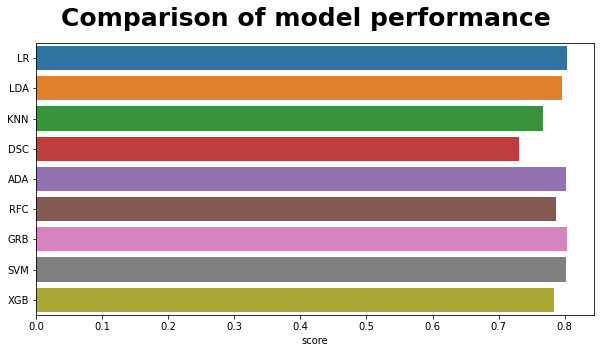

In [86]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='score', y=df_scores.index, data=df_scores)
plt.suptitle("Comparison of model performance", fontsize = 25, fontweight = 'bold')
fig.subplots_adjust(top=0.88)
plt.show()

### Hypothesis Testing

<p>We assume that the models LR, LDA, ADA and GRB perform similarly, but we want to test the null hypothesis, that all 4 models perform equally well.</p>

In [87]:
# evaluate model 1
model1 = models[0][1]
model1_name = models[0][0]
cv1 = kfold
scores1 = cross_val_score(model1, X_train, y_train, scoring = 'accuracy', cv = cv1, n_jobs = -1)
print(model1_name+' Mean Accuracy: %.1f%% +/-(%.3f)' % ((scores1*100).mean(), (scores1).std()))

# evaluate model 2
model2 = models[1][1]
model2_name = models[1][0]
cv2 = kfold
scores2 = cross_val_score(model2, X_train, y_train, scoring = 'accuracy', cv = cv2, n_jobs = -1)
print(model2_name+' Mean Accuracy: %.1f%% +/-(%.3f)' % ((scores2*100).mean(), (scores2).std()))

# evaluate model 3
model3 = models[4][1]
model3_name = models[4][0]
cv3 = kfold
scores3 = cross_val_score(model3, X_train, y_train, scoring = 'accuracy', cv = cv3, n_jobs = -1)
print(model3_name+' Mean Accuracy: %.1f%% +/-(%.3f)' % ((scores3*100).mean(), (scores3).std()))

# evaluate model 4
model4 = models[6][1]
model4_name = models[6][0]
cv4 = kfold
scores4 = cross_val_score(model4, X_train, y_train, scoring = 'accuracy', cv = cv4, n_jobs = -1)
print(model4_name+' Mean Accuracy: %.1f%% +/-(%.3f)' % ((scores4*100).mean(), (scores4).std()))



LR Mean Accuracy: 80.4% +/-(0.015)
LDA Mean Accuracy: 79.6% +/-(0.018)
ADA Mean Accuracy: 80.2% +/-(0.012)
GRB Mean Accuracy: 80.3% +/-(0.012)


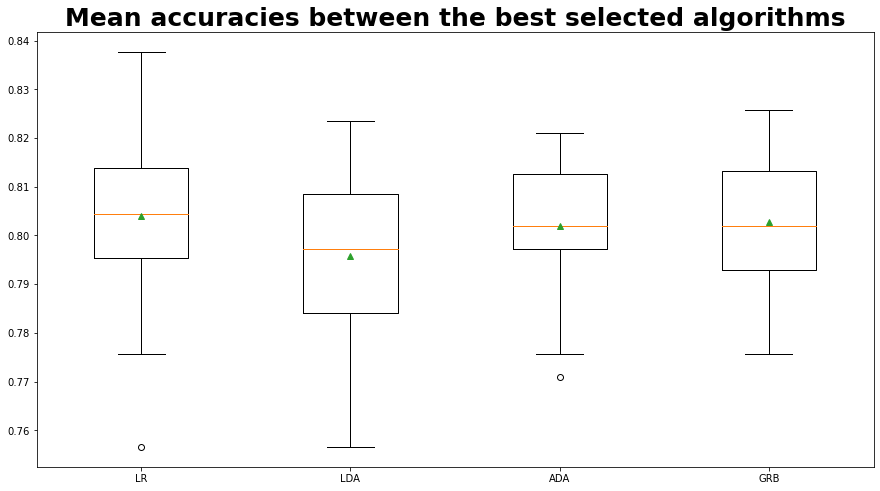

In [88]:
plt.figure(figsize = (15, 8))
plt.grid(False)
plt.title("Mean accuracies between the best selected algorithms", fontsize = 25, fontweight = 'bold')
plt.boxplot([scores1, scores2, scores3, scores4], labels=[model1_name, model2_name, model3_name, model4_name], showmeans=True)
plt.show()

### Hypothesis testing: pairwise comparison

In [89]:
from mlxtend.evaluate import paired_ttest_5x2cv
# check if difference between algorithms is real
t, p = paired_ttest_5x2cv(estimator1=model1, 
                          estimator2=model2,
                          X=X_train, 
                          y=y_train, 
                          scoring='accuracy', 
                          random_seed=1)
# summarize
print(f'The P-value is = {p:.3f}')
print(f'The t-statistics is = {t:.3f}')
# interpret the result
if p <= 0.05:
    print(f"Since p<0.05, We can reject the null-hypothesis that models {model1} and {model2} perform equally well on this dataset. We may conclude that the algorithms are significantly different.")
else:
    print(f"Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the models {model1} and {model2} is not significantly different.")

The P-value is = 0.789
The t-statistics is = 0.283
Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the models LogisticRegression(max_iter=1000) and LinearDiscriminantAnalysis() is not significantly different.


In [90]:
# check if difference between algorithms is real
t, p = paired_ttest_5x2cv(estimator1=model1, 
                          estimator2=model3,
                          X=X_train, 
                          y=y_train, 
                          scoring='accuracy', 
                          random_seed=1)
# summarize
print(f'The P-value is = {p:.3f}')
print(f'The t-statistics is = {t:.3f}')
# interpret the result
if p <= 0.05:
    print(f"Since p<0.05, We can reject the null-hypothesis that models {model1} and {model3} perform equally well on this dataset. We may conclude that the algorithms are significantly different.")
else:
    print(f"Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the models {model1} and {model3} is not significantly different.")

The P-value is = 0.955
The t-statistics is = -0.059
Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the models LogisticRegression(max_iter=1000) and AdaBoostClassifier(random_state=1) is not significantly different.


In [91]:
# check if difference between algorithms is real
t, p = paired_ttest_5x2cv(estimator1=model1, 
                          estimator2=model4,
                          X=X_train, 
                          y=y_train, 
                          scoring='accuracy', 
                          random_seed=1)
# summarize
print(f'The P-value is = {p:.3f}')
print(f'The t-statistics is = {t:.3f}')
# interpret the result
if p <= 0.05:
    print(f"Since p<0.05, We can reject the null-hypothesis that models {model1} and {model4} perform equally well on this dataset. We may conclude that the algorithms are significantly different.")
else:
    print(f"Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the models {model1} and {model4} is not significantly different.")

The P-value is = 0.419
The t-statistics is = 0.880
Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the models LogisticRegression(max_iter=1000) and GradientBoostingClassifier(random_state=1) is not significantly different.


In [92]:
# check if difference between algorithms is real
t, p = paired_ttest_5x2cv(estimator1=model2, 
                          estimator2=model3,
                          X=X_train, 
                          y=y_train, 
                          scoring='accuracy', 
                          random_seed=1)
# summarize
print(f'The P-value is = {p:.3f}')
print(f'The t-statistics is = {t:.3f}')
# interpret the result
if p <= 0.05:
    print(f"Since p<0.05, We can reject the null-hypothesis that models {model2} and {model3} perform equally well on this dataset. We may conclude that the algorithms are significantly different.")
else:
    print(f"Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the models {model2} and {model3} is not significantly different.")

The P-value is = 0.785
The t-statistics is = -0.288
Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the models LinearDiscriminantAnalysis() and AdaBoostClassifier(random_state=1) is not significantly different.


In [93]:
# check if difference between algorithms is real
t, p = paired_ttest_5x2cv(estimator1=model2, 
                          estimator2=model4,
                          X=X_train, 
                          y=y_train, 
                          scoring='accuracy', 
                          random_seed=1)
# summarize
print(f'The P-value is = {p:.3f}')
print(f'The t-statistics is = {t:.3f}')
# interpret the result
if p <= 0.05:
    print(f"Since p<0.05, We can reject the null-hypothesis that models {model2} and {model4} perform equally well on this dataset. We may conclude that the algorithms are significantly different.")
else:
    print(f"Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the models {model2} and {model4} is not significantly different.")

The P-value is = 0.267
The t-statistics is = 1.249
Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the models LinearDiscriminantAnalysis() and GradientBoostingClassifier(random_state=1) is not significantly different.


In [94]:
# check if difference between algorithms is real
t, p = paired_ttest_5x2cv(estimator1=model3, 
                          estimator2=model4,
                          X=X_train, 
                          y=y_train, 
                          scoring='accuracy', 
                          random_seed=1)
# summarize
print(f'The P-value is = {p:.3f}')
print(f'The t-statistics is = {t:.3f}')
# interpret the result
if p <= 0.05:
    print(f"Since p<0.05, We can reject the null-hypothesis that models {model3} and {model4} perform equally well on this dataset. We may conclude that the algorithms are significantly different.")
else:
    print(f"Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the models {model3} and {model4} is not significantly different.")

The P-value is = 0.195
The t-statistics is = 1.495
Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the models AdaBoostClassifier(random_state=1) and GradientBoostingClassifier(random_state=1) is not significantly different.


### ANOVA on all compared algorithms

In [95]:
# One-way ANOVA on all the algorithms

from scipy.stats import f_oneway

result_anova = f_oneway(scores1, scores2, scores3, scores4)
print(result_anova)

if result_anova[1] <= 0.05:
    print('Since p<0.05, We can reject the null-hypothesis that all models perform equally well on this dataset. We may conclude that the algorithms are significantly different.')
else:
    print('Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the algorithms is not significantly different.')

F_onewayResult(statistic=1.8035846350095055, pvalue=0.15039141155697414)
Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the algorithms is not significantly different.


<a name='C6'></a>
## <font color='darkblue'>__Hyperparameter tuning__</font>

### Manual Search

#### Logistic Regression

In [96]:
# Create a Logistic Regression Instance
lr = LogisticRegression()

# Hyperparameter Optimization
parameters = {'penalty': ['l2'],
              'C': [0.001,0.01,0.1,1,10,100],
              'max_iter': [1000000]
             }

# Run the grid search
clf = GridSearchCV(estimator=lr, 
                   param_grid=parameters,
                   cv=5,
                   scoring=f1_scorer,
                   verbose = 3,
                   refit = True,
                   n_jobs = -1)

search_lr = clf.fit(X_train, y_train)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.5s finished


In [97]:
pd.set_option('max_colwidth', None)
results_lr = pd.DataFrame(search_lr.cv_results_)
results_lr = results_lr[['params', 'rank_test_score', 'mean_test_score', 'std_test_score', 
                   'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']].sort_values(by=['rank_test_score'])
results_lr

,params,rank_test_score,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
3,"{'C': 1, 'max_iter': 1000000, 'penalty': 'l2'}",1,0.598253,0.015025,0.599520,0.616505,0.606796,0.597015,0.571429
4,"{'C': 10, 'max_iter': 1000000, 'penalty': 'l2'}",2,0.596849,0.013868,0.599520,0.611650,0.603865,0.598504,0.570707
5,"{'C': 100, 'max_iter': 1000000, 'penalty': 'l2'}",3,0.595585,0.012992,0.599520,0.608273,0.602410,0.597015,0.570707
2,"{'C': 0.1, 'max_iter': 1000000, 'penalty': 'l2'}",4,0.595172,0.019183,0.588808,0.617647,0.599509,0.608040,0.561856
1,"{'C': 0.01, 'max_iter': 1000000, 'penalty': 'l2'}",5,0.567507,0.023210,0.550129,0.597403,0.585242,0.571429,0.533333
0,"{'C': 0.001, 'max_iter': 1000000, 'penalty': 'l2'}",6,0.163045,0.031387,0.192000,0.147541,0.203125,0.156379,0.116183


#### Random Forest

In [98]:
# Setup parameters
n_estimators = [int(x) for x in np.linspace(start=100, stop=2000, num=10)]
max_features = ['log2', 'auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [2, 4, 8]
bootstrap = [True, False]
criterion = ['entropy', 'gini']


# Create a Random Forest Classifier
rf = RandomForestClassifier()

# Hyperparameter Optimization
parameters = {'n_estimators': n_estimators, 
              'max_features': max_features, 
              'criterion': criterion,
              'max_depth': max_depth, 
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap
             }


# Run Randomized Serch
clf = RandomizedSearchCV(estimator=rf,
                               param_distributions=parameters,
                               cv=5,
                               n_iter=15,
                               scoring=f1_scorer,
                               verbose = 3,
                               n_jobs = -1)                         

search_rf = clf.fit(X_train, y_train)


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  1.7min finished


In [99]:
pd.set_option('max_colwidth', None)
results_rf = pd.DataFrame(search_rf.cv_results_)
results_rf = results_rf[['params', 'rank_test_score', 'mean_test_score', 'std_test_score', 
                   'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']].sort_values(by=['rank_test_score'])
results_rf

,params,rank_test_score,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
8,"{'n_estimators': 1577, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 10, 'criterion': 'entropy', 'bootstrap': False}",1,0.582275,0.019709,0.585608,0.603491,0.565657,0.602532,0.554090
3,"{'n_estimators': 733, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini', 'bootstrap': False}",2,0.579062,0.017152,0.587940,0.603015,0.561224,0.585492,0.557641
4,"{'n_estimators': 944, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 60, 'criterion': 'gini', 'bootstrap': True}",3,0.573874,0.019979,0.576531,0.603015,0.547315,0.585752,0.556757
11,"{'n_estimators': 944, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 'auto', 'max_depth': 110, 'criterion': 'entropy', 'bootstrap': False}",4,0.571368,0.015429,0.575758,0.592405,0.562814,0.578947,0.546917
2,"{'n_estimators': 944, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 40, 'criterion': 'gini', 'bootstrap': True}",5,0.568860,0.021924,0.572152,0.603491,0.552430,0.576720,0.539510
14,"{'n_estimators': 2000, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 80, 'criterion': 'entropy', 'bootstrap': True}",6,0.568797,0.024156,0.572152,0.597990,0.541237,0.591623,0.540984
12,"{'n_estimators': 1577, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': 60, 'criterion': 'entropy', 'bootstrap': False}",7,0.568481,0.018208,0.575758,0.594458,0.549618,0.576623,0.545946
13,"{'n_estimators': 2000, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'auto', 'max_depth': None, 'criterion': 'entropy', 'bootstrap': True}",8,0.568040,0.019345,0.571429,0.587342,0.546392,0.590078,0.544959
1,"{'n_estimators': 522, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 70, 'criterion': 'entropy', 'bootstrap': True}",9,0.567714,0.025795,0.573604,0.610000,0.541772,0.573684,0.539510
9,"{'n_estimators': 311, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 60, 'criterion': 'gini', 'bootstrap': True}",10,0.567167,0.017911,0.577215,0.593350,0.550129,0.570667,0.544474


#### Linear Discriminant Analysis

In [100]:
# Create a Linear Discriminant Analysis Instance
ld = LinearDiscriminantAnalysis()

# Hyperparameter Optimization
parameters = {'solver': ['svd', 'lsqr', 'eigen'],
              'shrinkage': ['auto', 0.01, 0.05, 0.5, 1, None],
              'n_components': [-1],
              'store_covariance': [True, False]
             }

# Run the grid search
clf = GridSearchCV(estimator=ld, 
                   param_grid=parameters,
                   cv=5,
                   scoring=f1_scorer,
                   verbose = 3,
                   refit = True,
                   n_jobs = -1)

search_ld = clf.fit(X_train, y_train)


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 157 out of 180 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    1.3s finished


In [101]:
pd.set_option('max_colwidth', None)
results_ld = pd.DataFrame(search_ld.cv_results_)
results_ld = results_ld[['params', 'rank_test_score', 'mean_test_score', 'std_test_score', 
                   'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']].sort_values(by=['rank_test_score'])
results_ld

,params,rank_test_score,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
22,"{'n_components': -1, 'shrinkage': 0.5, 'solver': 'eigen', 'store_covariance': True}",1,0.627672,0.019727,0.606186,0.659619,0.633833,0.631347,0.607375
21,"{'n_components': -1, 'shrinkage': 0.5, 'solver': 'lsqr', 'store_covariance': False}",1,0.627672,0.019727,0.606186,0.659619,0.633833,0.631347,0.607375
20,"{'n_components': -1, 'shrinkage': 0.5, 'solver': 'lsqr', 'store_covariance': True}",1,0.627672,0.019727,0.606186,0.659619,0.633833,0.631347,0.607375
23,"{'n_components': -1, 'shrinkage': 0.5, 'solver': 'eigen', 'store_covariance': False}",1,0.627672,0.019727,0.606186,0.659619,0.633833,0.631347,0.607375
26,"{'n_components': -1, 'shrinkage': 1, 'solver': 'lsqr', 'store_covariance': True}",5,0.621708,0.004715,0.618182,0.628466,0.619137,0.626186,0.616570
28,"{'n_components': -1, 'shrinkage': 1, 'solver': 'eigen', 'store_covariance': True}",5,0.621708,0.004715,0.618182,0.628466,0.619137,0.626186,0.616570
29,"{'n_components': -1, 'shrinkage': 1, 'solver': 'eigen', 'store_covariance': False}",5,0.621708,0.004715,0.618182,0.628466,0.619137,0.626186,0.616570
27,"{'n_components': -1, 'shrinkage': 1, 'solver': 'lsqr', 'store_covariance': False}",5,0.621708,0.004715,0.618182,0.628466,0.619137,0.626186,0.616570
16,"{'n_components': -1, 'shrinkage': 0.05, 'solver': 'eigen', 'store_covariance': True}",9,0.599733,0.017944,0.598131,0.627635,0.597156,0.604317,0.571429
15,"{'n_components': -1, 'shrinkage': 0.05, 'solver': 'lsqr', 'store_covariance': False}",9,0.599733,0.017944,0.598131,0.627635,0.597156,0.604317,0.571429


#### Ada Boost

In [104]:
n_estimators = [50, 100, 200, 500, 1000, 1500]
learning_rate = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
algorithm = ['SAMME', 'SAMME.R']


# Create an Ada Boost Instance
adb = AdaBoostClassifier()

# Hyperparameter Optimization
parameters = {'n_estimators': n_estimators,
              'learning_rate': learning_rate,
              'algorithm': algorithm,
              'random_state': [0]
             }

# Run the grid search
clf = GridSearchCV(estimator=adb, 
                   param_grid=parameters,
                   cv=5,
                   scoring=f1_scorer,
                   verbose = 3,
                   refit = True,
                   n_jobs = -1)

search_adb = clf.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  4.0min finished


In [106]:
pd.set_option('max_colwidth', None)
results_adb = pd.DataFrame(search_adb.cv_results_)
results_adb = results_adb[['params', 'rank_test_score', 'mean_test_score', 'std_test_score', 
                   'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']].sort_values(by=['rank_test_score'])
results_adb

,params,rank_test_score,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
35,"{'algorithm': 'SAMME', 'learning_rate': 0.5, 'n_estimators': 1500, 'random_state': 0}",1,0.596466,0.015262,0.588235,0.605459,0.583942,0.622222,0.582474
34,"{'algorithm': 'SAMME', 'learning_rate': 0.5, 'n_estimators': 1000, 'random_state': 0}",2,0.593335,0.018394,0.582716,0.605459,0.587379,0.621891,0.569231
66,"{'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 50, 'random_state': 0}",3,0.592548,0.013854,0.598039,0.594458,0.579075,0.614634,0.576531
61,"{'algorithm': 'SAMME.R', 'learning_rate': 0.3, 'n_estimators': 100, 'random_state': 0}",4,0.591039,0.011871,0.601467,0.603015,0.574209,0.597015,0.579487
33,"{'algorithm': 'SAMME', 'learning_rate': 0.5, 'n_estimators': 500, 'random_state': 0}",5,0.590689,0.023505,0.583333,0.595533,0.575610,0.633416,0.565553
...,...,...,...,...,...,...,...,...,...
37,"{'algorithm': 'SAMME.R', 'learning_rate': 0.01, 'n_estimators': 100, 'random_state': 0}",67,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"{'algorithm': 'SAMME', 'learning_rate': 0.01, 'n_estimators': 200, 'random_state': 0}",67,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,"{'algorithm': 'SAMME', 'learning_rate': 0.01, 'n_estimators': 100, 'random_state': 0}",67,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,"{'algorithm': 'SAMME', 'learning_rate': 0.05, 'n_estimators': 50, 'random_state': 0}",67,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Create a pipeline with Scaler and Encoder

In [ ]:
categorical_features = list(cat_cols)
numeric_features = list(num_cols)


# The numeric data is standard-scaled
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

# The categorical data is one-hot encoded
categorical_transformer = Pipeline(
    steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))]
)

# Setup the column transformer, which allows to apply different preprocessing steps for individual sets of columns
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

<a name='C7'></a>
## <font color='darkblue'>__Compare model performance__</font>

In [108]:
model1 = search_lr.best_estimator_
class_labels = model1.classes_

model1.fit(X_train, y_train)

predictions = model1.predict(X_test)
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions), columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

          No       0.83      0.90      0.87      1320
         Yes       0.64      0.51      0.57       476

    accuracy                           0.80      1796
   macro avg       0.74      0.70      0.72      1796
weighted avg       0.78      0.80      0.79      1796



,No,Yes
No,1187,133
Yes,235,241


In [109]:
model2 = search_ld.best_estimator_
class_labels = model2.classes_

model2.fit(X_train, y_train)

predictions = model2.predict(X_test)
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions), columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

          No       0.86      0.84      0.85      1320
         Yes       0.58      0.63      0.61       476

    accuracy                           0.78      1796
   macro avg       0.72      0.74      0.73      1796
weighted avg       0.79      0.78      0.79      1796



,No,Yes
No,1104,216
Yes,174,302


In [110]:
model3 = search.best_estimator_
class_labels = model3.classes_

model3.fit(X_train, y_train)

predictions = model3.predict(X_test)
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions), columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

          No       0.84      0.90      0.87      1320
         Yes       0.65      0.52      0.58       476

    accuracy                           0.80      1796
   macro avg       0.74      0.71      0.72      1796
weighted avg       0.79      0.80      0.79      1796



,No,Yes
No,1187,133
Yes,228,248


<a name='C8'></a>
## <font color='darkblue'>__Select final model and save model artifacts__</font>

In [111]:
final_model = model1

In [112]:
model_artifacts = {
    'dummy_encoder': cat_dummy_encoder,
    'cat_init_features': cat_cols.values,
    'num_init_features': num_cols.values,
    'cat_ohe_features': cat_ohe_cols,
    'cat_imputer': cat_imputer,
    'num_imputer': knn_imp,
    'scaler': scaler,
    'ldisc_model': final_model,
    'column_names_order': final_dataset_columns
}

### Save model artifacts

In [113]:
import dill
!pwd
!mkdir ../ml_app/saved_models

'pwd' is not recognized as an internal or external command,
operable program or batch file.
The syntax of the command is incorrect.


In [114]:
with open("../ml_app/saved_models/churn_ldisc_artifacts.pkl", "wb") as dill_file:
    dill.dump(model_artifacts, dill_file)

In [115]:
!tree ../

Folder PATH listing for volume Windows 
Volume serial number is 0000006D D81D:A3BE
C:\USERS\AKOSR\ML_MINIPROJECT\ML_TELECOM_CHURN
ÃÄÄÄ.idea
³   ÃÄÄÄinspectionProfiles
³   ÀÄÄÄZeppelinRemoteNotebooks
ÃÄÄÄ.ipynb_checkpoints
ÃÄÄÄdatasets
ÃÄÄÄml_app
³   ÃÄÄÄdata_processing
³   ÃÄÄÄmodeling
³   ÃÄÄÄsaved_models
³   ÀÄÄÄutils
ÀÄÄÄnotebooks
    ÀÄÄÄ.ipynb_checkpoints


<a name='C9'></a>
## <font color='darkblue'>__Predict and draw conclusions__</font>

### Load Data

In [132]:
df = pd.read_csv('../datasets/telecom_users.csv')
final_columns = set(df.columns) - set(['Unnamed: 0'])
final_columns = list(final_columns)
df = df[final_columns]

In [133]:
# Impute Data and make necessary conversions
df['SeniorCitizen'] = df['SeniorCitizen'].replace({0: "No", 1: "Yes"})
df['TotalCharges'] = df['TotalCharges'].replace({" ": np.nan})
df['TotalCharges'] = np.where(df['TotalCharges'].isnull(), df['MonthlyCharges'], df['TotalCharges'])
df['TotalCharges'] = df['TotalCharges'].astype(float)
df['tenure'] = df['tenure'].replace({0: 1})

In [134]:
X = df.drop(columns=['Churn', 'customerID'])
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [135]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1796 entries, 3564 to 4851
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            1796 non-null   object 
 1   tenure            1796 non-null   int64  
 2   PaymentMethod     1796 non-null   object 
 3   InternetService   1796 non-null   object 
 4   OnlineSecurity    1796 non-null   object 
 5   TechSupport       1796 non-null   object 
 6   PaperlessBilling  1796 non-null   object 
 7   MonthlyCharges    1796 non-null   float64
 8   MultipleLines     1796 non-null   object 
 9   PhoneService      1796 non-null   object 
 10  Dependents        1796 non-null   object 
 11  SeniorCitizen     1796 non-null   object 
 12  OnlineBackup      1796 non-null   object 
 13  StreamingTV       1796 non-null   object 
 14  Partner           1796 non-null   object 
 15  TotalCharges      1796 non-null   float64
 16  DeviceProtection  1796 non-null   objec

### Load saved Model Artifacts

In [136]:
with open("../ml_app/saved_models/churn_ldisc_artifacts.pkl", "rb") as dill_infile:
    ldisc_model_artifacts = dill.load(dill_infile)

In [137]:
ldisc_model_artifacts

{'dummy_encoder': OneHotEncoder(handle_unknown='ignore'),
 'cat_init_features': array(['gender', 'PaymentMethod', 'InternetService', 'OnlineSecurity',
        'TechSupport', 'PaperlessBilling', 'MultipleLines', 'PhoneService',
        'Dependents', 'SeniorCitizen', 'OnlineBackup', 'StreamingTV',
        'Partner', 'DeviceProtection', 'StreamingMovies', 'Contract'],
       dtype=object),
 'num_init_features': array(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype=object),
 'cat_ohe_features': array(['gender_Female', 'gender_Male',
        'PaymentMethod_Bank transfer (automatic)',
        'PaymentMethod_Credit card (automatic)',
        'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
        'InternetService_DSL', 'InternetService_Fiber optic',
        'InternetService_No', 'OnlineSecurity_No',
        'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
        'TechSupport_No', 'TechSupport_No internet service',
        'TechSupport_Yes', 'PaperlessBilling_No

In [138]:
categorical_features_init = ldisc_model_artifacts['cat_init_features']
categorical_features_ohe = ldisc_model_artifacts['cat_ohe_features']
numeric_features_init = ldisc_model_artifacts['num_init_features']
column_names = ldisc_model_artifacts['column_names_order']

categorical_imputer = ldisc_model_artifacts['cat_imputer']
categorical_ohe = ldisc_model_artifacts['dummy_encoder']

numeric_imputer = ldisc_model_artifacts['num_imputer']
st_scaler = ldisc_model_artifacts['scaler']

ml_model = ldisc_model_artifacts['ldisc_model']

### Pre-processing and Feature Encoding

In [139]:
X_test_cat = X_test[categorical_features_init]
X_test_num = X_test[numeric_features_init]

X_test_cat = pd.DataFrame(categorical_imputer.transform(X_test_cat), 
                          columns=categorical_features_init)
X_test_cat_ohe = categorical_ohe.transform(X_test_cat).toarray()
X_test_cat_ohe = pd.DataFrame(X_test_cat_ohe, 
                               columns=categorical_features_ohe)

X_test_num = pd.DataFrame(numeric_imputer.transform(X_test_num), columns=numeric_features_init)
X_test_num = pd.DataFrame(st_scaler.transform(X_test_num), columns=numeric_features_init)


X_test = pd.concat([X_test_num, X_test_cat_ohe], axis=1)
X_test = X_test[column_names]
X_test.head(3)

,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_DSL,...,StreamingTV_Yes,Partner_No,Partner_Yes,DeviceProtection_No,DeviceProtection_Yes,StreamingMovies_No,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year
0,-1.281158,-0.489235,-0.983174,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1.545103,0.309314,1.294997,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,1.299341,1.317400,2.029444,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [140]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1796 entries, 0 to 1795
Data columns (total 39 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   tenure                                   1796 non-null   float64
 1   MonthlyCharges                           1796 non-null   float64
 2   TotalCharges                             1796 non-null   float64
 3   gender_Female                            1796 non-null   float64
 4   gender_Male                              1796 non-null   float64
 5   PaymentMethod_Bank transfer (automatic)  1796 non-null   float64
 6   PaymentMethod_Credit card (automatic)    1796 non-null   float64
 7   PaymentMethod_Electronic check           1796 non-null   float64
 8   PaymentMethod_Mailed check               1796 non-null   float64
 9   InternetService_DSL                      1796 non-null   float64
 10  InternetService_Fiber optic              1796 no

### ML Model Inference

In [141]:
predictions = ml_model.predict(X_test)
predictions

array(['No', 'No', 'No', ..., 'No', 'Yes', 'No'], dtype=object)

In [142]:
labels = ml_model.classes_

print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions), columns=labels, index=labels)

              precision    recall  f1-score   support

          No       0.83      0.90      0.87      1320
         Yes       0.64      0.51      0.57       476

    accuracy                           0.80      1796
   macro avg       0.74      0.70      0.72      1796
weighted avg       0.78      0.80      0.79      1796



,No,Yes
No,1187,133
Yes,235,241
